# Working with Landsat Thematic Mapper Imagery


![](http://esri.github.io/arcgis-python-api/notebooks/nbimages/02_change_detection_app_01.gif)

# Questions
- How does land change manifest itself in time-series of multispectral imagery?
- Can you identify when a significant disturbance occurred?

# Let's explore Landsat Thematic Mapper Data over a period of 30 years!

- About 20 years ago, my house was farmland 
- Can we use the 30 years of TM data to identify when development occurred? 

# Let's get started!

# Imports

In [1]:
from arcgis.features import SpatialDataFrame
from arcgis.raster.functions import *
from arcgis.raster import ImageryLayer
from arcgis.geometry import Geometry
from arcgis.geometry import Point
from arcgis.gis import GIS

# Log into Portal

In [2]:
gis = GIS('http://fedciv.esri.com/portal', 'GBrunner')

Enter password: ········


# Two Services:
- Landsat Thematic Mapper Multispectral Service
  - 8 Bands (7 Spectral and QA Band)
- Landsat Thematic Mapper NDVI Service
  - 2 Bands (NDVI and QA values)

In [3]:
ndvi_svc ="https://fedciv.esri.com/imageserver/rest/services/LandsatTM_NDVI/ImageServer"
ms_svc = "https://fedciv.esri.com/imageserver/rest/services/LandsatTM_MS/ImageServer"
ndvi_lyr = ImageryLayer(ndvi_svc, gis=gis)
ms_lyr = ImageryLayer(ms_svc, gis=gis)

# How does land change manifest itself in multispectral imagery?

## To investigate, let's go to my house!

## ... in O'Fallon, MO

# Here is my home

In [4]:
geometry = Point({"x" :-10093991.604, "y" : 4689459.491, "spatialReference" : {"wkid" : 102100}})
map1 = gis.map("122 Arabian Path, O'Fallon, MO, USA")
map1

MapView(layout=Layout(height='400px', width='100%'))

# I changed the basemap and the zoom

In [5]:
map1.zoom = 14
map1.basemap = 'satellite'

# I defined a symbol and drew it on the map

In [6]:
symbol = {"color":[128,0,0,128],
                    "size":18,
                    "angle":0,
                    "xoffset":0,
                    "yoffset":0,
                    "type":"esriSMS",
                    "style":
                    "esriSMSCircle",
                    "outline":
                        {"color":[128,0,0,255],
                         "width":1,
                         "type":"esriSLS",
                         "style":"esriSLSSolid"}
}
map1.draw(geometry, symbol=symbol)

# How many Landsat TM rasters are over O'Fallon, MO?

## I can query the data frame using a spatial filter

In [7]:
from arcgis.geometry import filters

geometry = Point({"x" :-10093991.604, "y" : 4689459.491, "spatialReference" : {"wkid" : 102100}})
sp_filter = filters.intersects(geometry=geometry)
im_sdf = ms_lyr.query(geometry_filter=sp_filter, return_all_records=True).df

# There are 563 Landsat TM Images over O'Fallon

In [8]:
len(im_sdf)

563

# What does that data frame look like?

In [9]:
im_sdf.head(3)

,AcquisitionDate,Best,Category,CenterX,CenterY,CloudCover,Dataset_ID,GroupName,HighPS,LANDSAT_PRODUCT_ID,...,Shape_Area,Shape_Length,SunAzimuth,SunElevation,Tag,WRS_PATH,WRS_ROW,ZOrder,dayofYear,SHAPE
0,407779836919,562976033,1,-1.010862e+07,4.707142e+06,1.00,TM,LT04_L1GS_024033_19821203_20161005_01_T2_MTL,120,LT04_L1GS_024033_19821203_20161005_01_T2_MTL.txt,...,4.841470e+10,880790.837585,153.899125,24.435911,MS,24,33,None,337,"{'rings': [[[-9972665.7049, 4791716.445500001]..."
1,409162217912,457976033,1,-1.009491e+07,4.704437e+06,0.91,TM,LT04_L1GS_024033_19821219_20161005_01_T2_MTL,120,LT04_L1GS_024033_19821219_20161005_01_T2_MTL.txt,...,4.842517e+10,880897.226564,152.774083,22.629936,MS,24,33,None,353,"{'rings': [[[-9958787.6726, 4788804.661499999]..."
2,411927071855,370976033,1,-1.011066e+07,4.707564e+06,0.65,TM,LT04_L1GS_024033_19830120_20161004_01_T2_MTL,120,LT04_L1GS_024033_19830120_20161004_01_T2_MTL.txt,...,4.836119e+10,880270.768558,148.182328,24.292955,MS,24,33,None,20,"{'rings': [[[-9974967.0134, 4792249.327500001]..."


# How do I interpret the "AcquisitionDate"?
- I need to convert from Unix time into a datetime

In [10]:
import pandas as pd

im_sdf['Date'] =  pd.to_datetime(im_sdf['AcquisitionDate'], unit='ms')
im_sdf['Date'].head()

0   1982-12-03 16:10:36.919
1   1982-12-19 16:10:17.912
2   1983-01-20 16:11:11.855
3   1983-02-05 16:11:21.834
4   1982-11-17 16:10:16.657
Name: Date, dtype: datetime64[ns]

# I'm interested in cloud free images

In [11]:
im_sdf[im_sdf['CloudCover']<.10].Date.head()

4    1982-11-17 16:10:16.657
5    1983-01-04 16:10:48.224
10   1984-10-13 16:12:09.654
32   1988-07-20 16:12:47.393
34   1988-12-27 16:12:23.535
Name: Date, dtype: datetime64[ns]

# I found some:
- From 1982: 'LT40240331982321XXX04'
- From 2010: 'LT50240332010102EDC00'

In [13]:
selected_oldest = ms_lyr.filter_by(where="Name = 'LT40240331982321XXX04'")
selected_newest = ms_lyr.filter_by(where="Name = 'LT50240332010102EDC00'")

# Let's look at O'Fallon in 1982 and 2010

In [14]:
map_old = gis.map(location="122 Arabian Path, O'Fallon, MO")#, zoomlevel=14)
map_new = gis.map(location="122 Arabian Path, O'Fallon, MO")#, zoomlevel=14)

In [15]:
from ipywidgets import *

map_old.layout=Layout(flex='1 1', padding='10px',height='500px', min_width='40px')
map_new.layout=Layout(flex='1 1', padding='10px',height='500px', min_width='40px')
box = HBox([map_old, map_new])
box

In [17]:
map_old.add_layer(stretch(extract_band(selected_oldest,[2,1,0]),
                         stretch_type='StdDev',
                         num_stddev=2.5,
                         dra=True))

map_new.add_layer(stretch(extract_band(selected_newest,[2,1,0]),
                         stretch_type='StdDev',
                         num_stddev=2.5,
                         dra=True))

In [16]:
map_old

MapView(layout=Layout(height='400px', width='100%'))

In [17]:
map_new

MapView(layout=Layout(height='400px', width='100%'))

In [18]:
map_new.zoom = 14
map_old.zoom = 14
map_old.draw(geometry, symbol=symbol)
map_new.draw(geometry, symbol=symbol)

# Using NDVI to pinpoint when my home was built

# What is NDVI?
- Normalized Difference Vegetation Index
- For Landsat TM
  - `NDVI = (NIR_4 - VIS_3)/(NIR_4 + VIS_3)`
- Result will be between -1 and 1

# What does NDVI Typically looks like?

In [19]:
agol_gis = GIS("http://ps-dbs.maps.arcgis.com/home", "gregbrunner_dbs")
landsat_lyr = ImageryLayer("https://landsat2.arcgis.com/arcgis/rest/services/Landsat8_Views/ImageServer",
                        gis=agol_gis)

Enter password: ········


In [20]:
l8_map = agol_gis.map('122 Arabian Path, St. Peters, MO 63376')
l8_map

MapView(layout=Layout(height='400px', width='100%'))

# Landsat Raster Functions

In [31]:
landsat_lyr.properties.rasterFunctionInfos

[{
   "name": "Agriculture with DRA",
   "description": "Bands shortwave IR-1, near-IR, blue (6, 5, 2) with dynamic range adjustment applied on apparent reflectance. Vigorous veg. is bright green, stressed veg. dull green and bare areas as brown.",
   "help": ""
 }, {
   "name": "Bathymetric with DRA",
   "description": "Bands red, green, coastal/aerosol (4, 3, 1) with dynamic range adjustment applied on apparent reflectance. Useful in bathymetric mapping applications.",
   "help": ""
 }, {
   "name": "Color Infrared with DRA",
   "description": "Bands near-IR, red, green (5, 4, 3) with dynamic range adjustment applied on apparent reflectance. Healthy vegetation is bright red while stressed vegetation is dull red.",
   "help": ""
 }, {
   "name": "Natural Color with DRA",
   "description": "Natural Color bands red, green, blue (4, 3, 2) displayed with dynamic range adjustment applied on apparent reflectance.",
   "help": ""
 }, {
   "name": "Short-wave Infrared with DRA",
   "descripti

In [21]:
l8_map.add_layer(apply(landsat_lyr, 'NDVI Colorized'))
l8_map.zoom = 14

# How do I get pixel values over time at a given location?

In [ ]:
pixel_location = Point({"x" :-10093991.604, "y" : 4689459.491, "spatialReference" : {"wkid" : 102100}})
time = []
dtime = []
pixels = []

for idx,row in enumerate(im_sdf.iterrows()):
    oid = str(row[1]['OBJECTID'])
    image_at_t = ndvi_lyr.filter_by(where="OBJECTID = "+oid)#, geometry=the_geom)
    pixel = image_at_t.identify(geometry=pixel_location)#, time_extent=t)
    try:
        pix = [float(x) for x in pixel['value'].split(',')]
        pixels.append(pix)
        time.append(float(row[1]['AcquisitionDate']))
        dtime.append(row[1]['Date'])
    except:
        print("NoData")

In [ ]:
#import pickle

#pixels_pickle = open("ndvi_vals.p","wb")
#pickle.dump(pixels, pixels_pickle)
#pixels_pickle.close()

#dtime_pickle = open("dtime_vals.p","wb")
#pickle.dump(dtime, dtime_pickle)
#dtime_pickle.close()

#time_pickle = open("time_vals.p","wb")
#pickle.dump(time, time_pickle)
#time_pickle.close()

In [21]:
import pickle

pixels = pickle.load(open("ndvi_vals.p","rb"))
dtime = pickle.load(open("dtime_vals.p","rb"))
time = pickle.load(open("time_vals.p","rb"))

# What are NDVI the pixel values?

In [22]:
pixels[:5]

[[0.133884, 756.0],
 [0.146356, 752.0],
 [0.207259, 752.0],
 [0.146495, 752.0],
 [0.548569, 672.0]]

### The first column is the NDVI value, the second is the QA Band value

# What is the Landsat QA Band?
<!--<img src="https://landsat.usgs.gov/sites/default/files/images/C1-BQA-Example.jpg" width="400" class="center"/>-->
<img src="https://hyspeedblog.files.wordpress.com/2014/08/landsat8_lake_tahoe.jpg" width="400" class="center"/>

### https://landsat.usgs.gov/collectionqualityband

# I can separate the NDVI values and QA values into separate lists

In [23]:
qa_band = []
pixel_values = []
for pix in pixels:
    qa_band.append(pix[1])
    pixel_values.append(pix[0])

In [24]:
qa_band[:5]

[756.0, 752.0, 752.0, 752.0, 672.0]

# What does the NDVI curve look like?

I'll do this first without any filtering and it's hard to whether there is a trend.

# Plotting parameters

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-darkgrid')

Text(0,0.5,'NDVI')

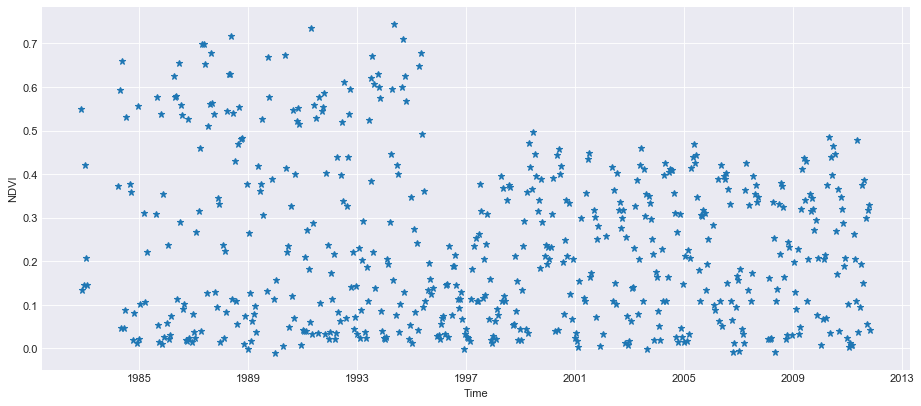

In [26]:
fig=plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(dtime, pixel_values, '*',label='linear') #indicde 0 is max
plt.xlabel('Time')
plt.ylabel('NDVI')

## Let's Filter the QA Bands

We can use the Landsat QA band to filter out snow, ice, and clouds. Here we wll apply that filter.

In [28]:
LANDSAT_5_CLEAR_PIX_VALS = [672, 676, 680, 684]
QA_BAND_IND = 1

clear_indices = [x for x in range(len(qa_band)) if qa_band[x] in LANDSAT_5_CLEAR_PIX_VALS]

# Let's only use times and pixels that are "clear"

In [29]:
clear_pix = [pixel_values[val] for val in  clear_indices]
clear_time = [time[x] for x in clear_indices]
clear_dtime = [dtime[x] for x in clear_indices]

# I'll sort the data too

In [30]:
import numpy as np

sorted_t = np.sort(clear_dtime)
sorted_t_idx = np.argsort(clear_dtime)

sorted_clear_time = np.sort(clear_time)

sorted_clear_pix = [clear_pix[int(sorted_idx)] for sorted_idx in sorted_t_idx]

# Now, what does the plot look like now?

Text(0,0.5,'NDVI')

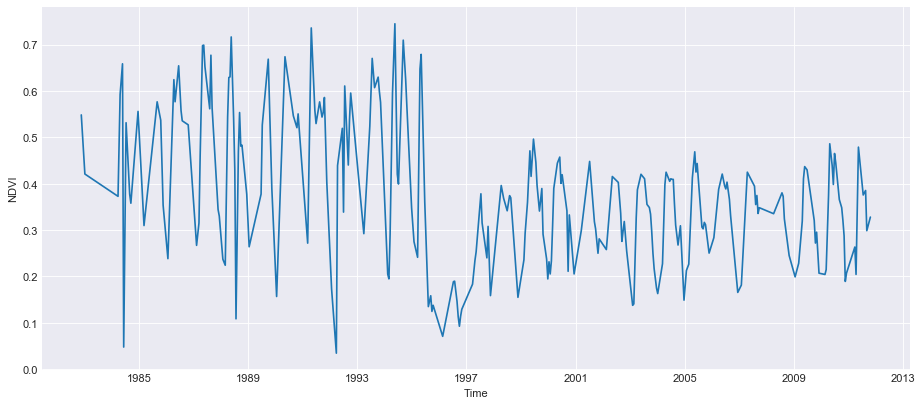

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(sorted_t, sorted_clear_pix,label='linear') #indicde 0 is max
plt.xlabel('Time')
plt.ylabel('NDVI')

# It looks like something changed between 1996 and 1998
- Higher max NDVI values from 1980 through 1996.
- The range of NDVI values becomes more narrow from 1997 onward.

# Let's look at some images from 1996 and 1997
- Filter on cloud cover and date range to identify cloud free images from 1996 and 1997

# 1996

In [22]:
date_df = im_sdf[im_sdf['CloudCover']<.10]
date_df[(date_df['Date'] > '1996-01-01') & (date_df['Date'] < '1997-01-01')]
date_df.head(3)

,AcquisitionDate,Best,Category,CenterX,CenterY,CloudCover,Dataset_ID,GroupName,HighPS,LANDSAT_PRODUCT_ID,...,Shape_Length,SunAzimuth,SunElevation,Tag,WRS_PATH,WRS_ROW,ZOrder,dayofYear,SHAPE,Date
4,406397416657,151976033,1,-1.010513e+07,4.706396e+06,0.00,TM,LT04_L1TP_024033_19821117_20161005_01_T1_MTL,120,LT04_L1TP_024033_19821117_20161005_01_T1_MTL.txt,...,880376.309735,153.749175,27.723675,MS,24,33,None,321,"{'rings': [[[-9969202.4746, 4790873.252599999]...",1982-11-17 16:10:16.657
5,410544648224,150976033,1,-1.010359e+07,4.706114e+06,0.00,TM,LT04_L1TP_024033_19830104_20161004_01_T1_MTL,120,LT04_L1TP_024033_19830104_20161004_01_T1_MTL.txt,...,880252.367092,150.749726,22.549642,MS,24,33,None,4,"{'rings': [[[-9967658.3652, 4790701.680600002]...",1983-01-04 16:10:48.224
10,466531929654,192976033,1,-1.011276e+07,4.708273e+06,0.07,TM,LT05_L1GS_024033_19841013_20161004_01_T2_MTL,120,LT05_L1GS_024033_19841013_20161004_01_T2_MTL.txt,...,880403.840984,148.836439,37.918357,MS,24,33,None,287,"{'rings': [[[-9976898.8592, 4792797.776100002]...",1984-10-13 16:12:09.654


In [23]:
map_1996 = gis.map("122 Arabian Path, O'Fallon, MO")
selected_1996 = ms_lyr.filter_by(where="Name = 'LT50240331996272XXX02'")

# 1997

In [24]:
date_df = im_sdf[im_sdf['CloudCover']<.10]
date_df[(date_df['Date'] > '1997-01-01') & (date_df['Date'] < '1998-01-01')].Name

337    LT50240331997082AAA02
339    LT50240331997130XXX02
341    LT50240331997194AAA02
342    LT50240331997210XXX01
346    LT50240331997274XXX02
347    LT50240331997290AAA02
348    LT50240331997322AAA02
Name: Name, dtype: object

In [25]:
map_1997 = gis.map("122 Arabian Path, O'Fallon, MO")
selected_1997 = ms_lyr.filter_by(where="Name = 'LT50240331997274XXX02'")

# 1996 and 1997

In [26]:
from ipywidgets import *

map_1996.layout=Layout(flex='1 1', padding='10px',height='500px', min_width='40px')
map_1997.layout=Layout(flex='1 1', padding='10px',height='500px', min_width='40px')
box = HBox([map_1996, map_1997])
box

# Adding the years

In [27]:
map_1996.add_layer(stretch(extract_band(selected_1996,[2,1,0]),
                         stretch_type='StdDev',
                         num_stddev=2.5,
                         dra=True))

In [29]:
map_1997.add_layer(stretch(extract_band(selected_1997,[2,1,0]),
                         stretch_type='StdDev',
                         num_stddev=2.5,
                         dra=True))

In [30]:
map_1996.zoom = 14
map_1996.draw(geometry, symbol=symbol)
map_1997.zoom = 14
map_1997.draw(geometry, symbol=symbol)

# Some other questions we could ask?
- How is this occuring across the counrty?
- Does this apply to other scenarios?
- How do you implement this as an algorithm that can be run nationally? globally?